### Sammenligning av områder innad i et HYPSO 1 bilde

##### Import


In [1]:
from hypso import Hypso1, Hypso2
import os 
import sys
import matplotlib.pyplot as plt
from global_land_mask import globe 
import numpy as np 

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import funcions_autonom as f
import atmosperic_correction as atm_c ## obs denne het før ac -> kan føre til feil dersom man ikke finner funkjsons navn
import base as ac

import xarray as xr
import re
import math
import importlib

from sklearn.cluster import KMeans
from collections import defaultdict

from sklearn.preprocessing import StandardScaler

np.random.seed(42)

dir_path = ".." ## filene hentes fra en mappe over der vi er nå

##### Uploading data

In [2]:
fro_230330 = os.path.join(dir_path, "frohavet_2023-03-30T10-30-26Z-l1a.nc")
fro_230330_b = os.path.join(dir_path, "frohavet_2023-03-30T10-30-26Z-l1b.nc")
fro_230330_c = os.path.join(dir_path, "frohavet_2023-03-30T10-30-26Z-l1c.nc")
fro_230330_d = os.path.join(dir_path, "frohavet_2023-03-30T10-30-26Z-l1d.nc")

satobj_h1_230330 = Hypso1( path = fro_230330, verbose = True )

l1a_cube_230330 = satobj_h1_230330.l1a_cube
l1b_cube_230330 = Hypso1( path = fro_230330_b, verbose = True )
l1c_cube_230330 = Hypso1( path = fro_230330_c, verbose = True )
l1d_cube_230330 = Hypso1( path = fro_230330_d, verbose = True )

l1c_cube_230330 = l1c_cube_230330.l1c_cube
l1b_cube_230330 = l1b_cube_230330.l1b_cube
l1d_cube_230330 = l1d_cube_230330.l1d_cube

satobj_h1_230330.run_direct_georeferencing() # in order to get the longiyudes and latitudes

[INFO] Loading L1a capture frohavet_2023-03-30T10-30-26Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Loading L1b capture frohavet_2023-03-30T10-30-26Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Loading L1c capture frohavet_2023-03-30T10-30-26Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Loading L1d capture frohavet_2023-03-30T10-30-26Z
[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Running direct georeferencing...
[INFO] ADCS samples: 1921
[INFO] ADCS time range: 1680171540.000000 to 1680172458.250000
[INFO] Frame time range: 1680172226.731407 to 1680172276.481407
[INFO] 199 sample(s) inside frame time range
[INFO] Interpolating 598 frames
[INFO] Computing pixel latitude and longitude coordinates ...
[INFO] Interpolating pixel coordinate gaps...
[INFO] Direct georeferencing done
[INFO] Running track geometry comput

##### Defining areas

In [3]:
#extract wanted waelengths
wl = satobj_h1_230330.wavelengths[4:118]
x_123 = [387.84749685, 391.40406599, 394.95941579, 398.51354623, 402.06645732, 405.61814905, 409.16862143, 412.71787446, 416.26590814, 419.81272246, 423.35831743, 426.90269305, 430.44584931, 433.98778622, 437.52850378, 441.06800198, 444.60628083, 448.14334033, 451.67918047, 455.21380126, 458.7472027, 462.27938479, 465.81034752, 469.3400909 , 472.86861492,476.3959196 , 479.92200491, 483.44687088, 486.97051749, 490.49294475,494.01415266, 497.53414122, 501.05291042, 504.57046026, 508.08679076,511.6019019 , 515.11579369, 518.62846612, 522.13991921, 525.65015294,529.15916731, 532.66696233, 536.173538  , 539.67889432, 543.18303128,546.68594889, 550.18764715, 553.68812606, 557.18738561, 560.68542581,564.18224665, 567.67784814, 571.17223028, 574.66539307, 578.1573365, 581.64806058, 585.1375653 , 588.62585068, 592.1129167 , 595.59876336,599.08339068, 602.56679864, 606.04898725, 609.5299565 , 613.0097064 ,616.48823695, 619.96554815, 623.44163999, 626.91651248, 630.39016561,633.86259939, 637.33381382, 640.8038089 , 644.27258462, 647.74014099,651.20647801, 654.67159568, 658.13549399, 661.59817294, 665.05963255,668.5198728 , 671.9788937 , 675.43669524, 678.89327744, 682.34864028,685.80278376, 689.25570789, 692.70741267, 696.1578981 , 699.60716418,703.0552109 , 706.50203826, 709.94764628, 713.39203494, 716.83520425,720.2771542 , 723.7178848 , 727.15739605, 730.59568795, 734.03276049,737.46861368, 740.90324752, 744.336662  , 747.76885713, 751.19983291,754.62958933, 758.0581264 , 761.48544412, 764.91154248, 768.33642149,771.76008115, 775.18252146, 778.60374241, 782.02374401, 785.44252625,788.86008915, 792.27643269, 795.69155687, 799.10546171, 802.51814719]
wl = x_123[4:118]

target_lat_6 = [64.48557437461893,64.52896641587218, 64.20992561747796, 64.22009411667561] #område 7
target_lon_6 = [9.886201113342556, 8.708294855080245,9.704720121565003,8.73032214102829]  

target_lat_5 = [64.17324887890479,64.11631446557637, 63.896904083590066, 63.887923483169004] #område 6.1
target_lon_5 = [9.582148298814932,8.924448409066027, 9.578289180688513, 8.96230357578283]

target_lat_3 = [63.818490304354434,63.793837321385155, 63.65192496143867, 63.660555970548074] #område 2.1.
target_lon_3 = [9.531415429238418, 9.442656298818237,9.526455044589706,9.439764451470932]

target_lat_2 = [63.646767083517425,63.61771951990031, 63.47865598622861, 63.42721372576498] #område 5.1
target_lon_2 = [9.804697410334523, 9.723689711502818,10.061035990832918,9.982929114384596]  

target_lat_1 = [63.52676744792975, 63.55113867486421, 63.44802428401152, 63.46332195091103] #område 8 
target_lon_1 = [10.726421572030368, 10.227932960954064, 10.706024496195505, 10.211631333282082] 

importlib.reload(ac)
importlib.reload(f)

<module 'funcions_autonom' from '/home/itk/Documents/AnneMarthe/Master/Hypos_analyse/funcions_autonom.py'>

##### ATm corrected data cube

In [4]:
cube_0330 = np.array(l1d_cube_230330[:,:, 4:118]) # get the toa reflectance cube
sat = np.max(l1a_cube_230330, axis = -1) > 35000 ##identifying saturated pixsels
T, S, objs = ac.atm_correction(cube_0330.reshape(-1,114), solar=np.ones(114), verbose = True, tol = 0.01, est_min_R = 0.05) # calculating transmission and scattering

cube_norm_0330 = (cube_0330 - S) /T
cube_norm_0330[sat] = np.nan #normalizing the cube and setting saturated pixels to nan

0.0035676612324148167
0.001245527125829396
0.0006724815614877414
0.0005202119703314721
0.00045535308963129975
0.0004240978869840134
0.00040827547054184295
0.0003999482628148956
0.00039519252738591325
0.00039218518750474787


##### RSS different areas

In [7]:
latitudes_0330 = satobj_h1_230330.latitudes
longitudes_0330 = satobj_h1_230330.longitudes

In [11]:
piksel_row_A1, piksel_col_A1 = f.latLong_to_piksel(target_lat_1, target_lon_1, latitudes_0330, longitudes_0330) #from file funcions_autonom.py
print(piksel_row_A1, piksel_col_A1) #sjekker at det er riktig

rss_A1 = f.hyps1_rss_matrix(cube_norm_0330, piksel_row_A1, piksel_col_A1, satobj_h1_230330) 
print(rss_A1.shape) #sjekker at det er riktig

median_A1_atmc = np.median(rss_A1, axis = 0)
median_A1_atmc.shape
normaized_spectrum_median_A1 = f.min_max_nomralization(median_A1_atmc)
l2_norm_A1 = np.linalg.norm(median_A1_atmc)  #l2 norm
l2_normalized_spectrum_A1 = median_A1_atmc / l2_norm_A1  #l2 normalisering

[np.int64(224), np.int64(219), np.int64(240), np.int64(237)] [np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
Pixel number:  7
(7, 114)


In [12]:
piksel_row_A2, piksel_col_A2 = f.latLong_to_piksel(target_lat_2, target_lon_2, latitudes_0330, longitudes_0330) #from file funcions_autonom.py
print(piksel_row_A2, piksel_col_A2) #sjekker at det er riktig

rss_A2 = f.hyps1_rss_matrix(cube_norm_0330, piksel_row_A2, piksel_col_A2, satobj_h1_230330) 
print(rss_A2.shape) #sjekker at det er riktig

median_A2_atmc = np.median(rss_A2, axis = 0)
median_A2_atmc.shape
normaized_spectrum_median_A2 = f.min_max_nomralization(median_A1_atmc)
l2_norm_A2 = np.linalg.norm(median_A2_atmc)  #l2 norm
l2_normalized_spectrum_A2 = median_A2_atmc / l2_norm_A2  #l2 normalisering

[np.int64(208), np.int64(215), np.int64(234), np.int64(244)] [np.int64(162), np.int64(200), np.int64(0), np.int64(0)]
Pixel number:  1534
(1534, 114)


In [13]:
piksel_row_A3, piksel_col_A3 = f.latLong_to_piksel(target_lat_3, target_lon_3, latitudes_0330, longitudes_0330) #from file funcions_autonom.py
print(piksel_row_A3, piksel_col_A3) #sjekker at det er riktig

rss_A3 = f.hyps1_rss_matrix(cube_norm_0330, piksel_row_A3, piksel_col_A3, satobj_h1_230330) 
print(rss_A3.shape) #sjekker at det er riktig

median_A3_atmc = np.median(rss_A3, axis = 0)
median_A3_atmc.shape
normaized_spectrum_median_A3 = f.min_max_nomralization(median_A1_atmc)
l2_norm_A3 = np.linalg.norm(median_A3_atmc)  #l2 norm
l2_normalized_spectrum_A3 = median_A3_atmc / l2_norm_A3  #l2 normalisering

[np.int64(185), np.int64(192), np.int64(215), np.int64(216)] [np.int64(447), np.int64(490), np.int64(350), np.int64(412)]
Pixel number:  519
(519, 114)


In [14]:
piksel_row_A5, piksel_col_A5 = f.latLong_to_piksel(target_lat_5, target_lon_5, latitudes_0330, longitudes_0330) #from file funcions_autonom.py
print(piksel_row_A5, piksel_col_A5) #sjekker at det er riktig

rss_A5 = f.hyps1_rss_matrix(cube_norm_0330, piksel_row_A5, piksel_col_A5, satobj_h1_230330) 
print(rss_A5.shape) #sjekker at det er riktig

median_A5_atmc = np.median(rss_A5, axis = 0)
median_A5_atmc.shape
normaized_spectrum_median_A5 = f.min_max_nomralization(median_A1_atmc)
l2_norm_A5 = np.linalg.norm(median_A5_atmc)  #l2 norm
l2_normalized_spectrum_A5 = median_A5_atmc / l2_norm_A5  #l2 normalisering

[np.int64(121), np.int64(150), np.int64(170), np.int64(189)] [np.int64(629), np.int64(1038), np.int64(463), np.int64(873)]
Pixel number:  5124
(5124, 114)


In [15]:
piksel_row_A6, piksel_col_A6 = f.latLong_to_piksel(target_lat_6, target_lon_6, latitudes_0330, longitudes_0330) #from file funcions_autonom.py
print(piksel_row_A6, piksel_col_A6) #sjekker at det er riktig

rss_A6 = f.hyps1_rss_matrix(cube_norm_0330, piksel_row_A6, piksel_col_A6, satobj_h1_230330) 
print(rss_A6.shape) #sjekker at det er riktig

median_A6_atmc = np.median(rss_A6, axis = 0)
median_A6_atmc.shape
normaized_spectrum_median_A6 = f.min_max_nomralization(median_A1_atmc)
l2_norm_A6 = np.linalg.norm(median_A6_atmc)  #l2 norm
l2_normalized_spectrum_A6 = median_A6_atmc / l2_norm_A6  #l2 normalisering

[np.int64(57), np.int64(69), np.int64(111), np.int64(131)] [np.int64(622), np.int64(1091), np.int64(570), np.int64(1091)]
Pixel number:  20210
(20210, 114)


##### Plot spectrums

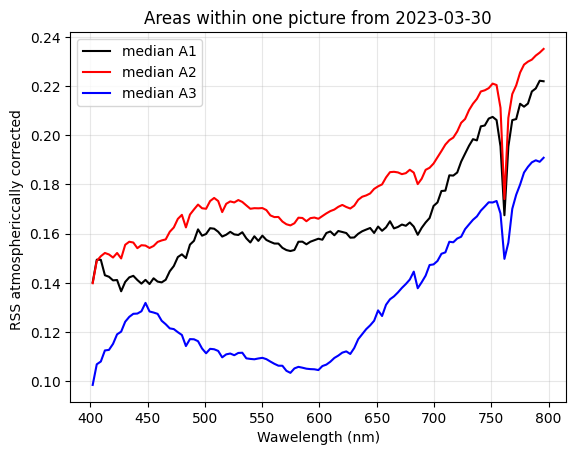

In [21]:
plt.plot(wl, median_A1_atmc, color='black', label='median A1')
plt.plot(wl, median_A2_atmc, color='red', label='median A2')
plt.plot(wl, median_A3_atmc, color='blue', label='median A3')
#plt.plot(wl, median_A5_atmc, color='green', label='median A5')
#plt.plot(wl, median_A6_atmc, color='orange', label='median A6')

#plt.plot(wl, normaized_spectrum_median_0328, color='black', linestyle='--', label='normaized median 0328')
#plt.plot(wl, normaized_spectrum_median_0329, color='red', linestyle='--', label='normaized median 0329')
#plt.plot(wl, normaized_spectrum_median_0330, color='blue', linestyle='--', label='normaized median 0330')

#plt.plot(wl, l2_normalized_spectrum_0328, color='black', label='l2 normalized median 0328')
#plt.plot(wl, l2_normalized_spectrum_0329, color='red', label='l2 normalized median 0329')
#plt.plot(wl, l2_normalized_spectrum_0330, color='blue', label='l2 normalized median 0330')

plt.xlabel("Wawelength (nm)")
plt.ylabel("RSS atmosphericcally corrected ") #finne enheten her [sr^{-1}]
plt.title("Areas within one picture from 2023-03-30")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
